# TVA

In [3]:
import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.outcomes import plurality_outcome
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
import os
import numpy as np

In [4]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

This is the voting input

In [5]:
voting = utils.read_voting(path_voting, table_name="voting5")
voting_table = voting.to_pandas()
voting_table


,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


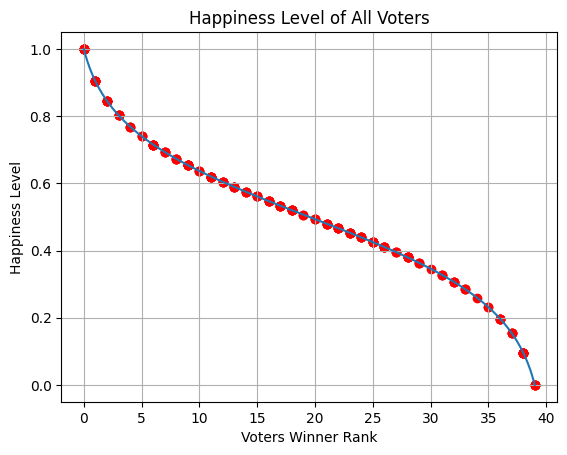

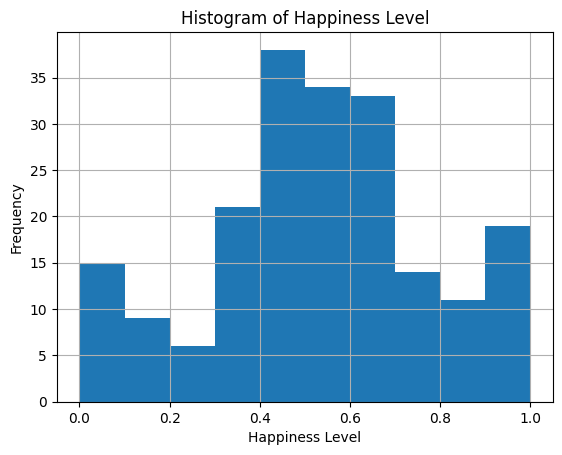

In [6]:
random_voting = utils.random_voting(200, 40)

result_random = plurality_outcome(random_voting)
happiness_level = HappinessLevel(random_voting, result_random.winner)
happiness_level.plot()
happiness_level.histogram()

## Strategic Voting

In [7]:
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


In [ ]:
result = plurality_outcome(voting)
result

Winner: C
{'A': 1, 'B': 2, 'C': 3, 'D': 0}

Note that **voter 5** is the only voter that can engage in strategic voting. Voter 5 prefers $B$ over the winner $C$. Hence, they can increase their $\text{Happiness Level}$ by placing $B$ as their first preference, resulting in a tie between $C$ and $B$ in the voting outcome (for plurality, voting for two, Borda). Since ties are resolved in alphabetical order, $B$ wins over $C$.

The table below displays the two voting strategies available to voter 5.

In [ ]:
happiness_level = HappinessLevel(voting, result.winner)
strategic_voting = StrategicVoting(voting).run(happiness_level, plurality_outcome)

strategic_voting.all

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487
1,5,"[B, D, A, C]",B,0.410487,0.0,2.820973,3.410487


The table displays the best strategic voting for each voter

In [ ]:
strategic_voting.best

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487


Strategic Voting Risk

In [ ]:
strategic_voting.risk

0.13682886358890622

## Coalition Voting

In [83]:
voting = utils.read_voting(path_voting, table_name="voting10")
voting_table = voting.to_pandas()
voting_table

,voter_0,voter_1,voter_2
preference_0,A,B,C
preference_1,B,C,A
preference_2,C,A,B


In [84]:
from importlib import reload
import src.coalition_evaluator as coalition_evaluator
reload(coalition_evaluator)
# successful_coalitions_plurality = coalition_evaluator.evaluate_coalition_strategic_voting_plurality(voting)
# successful_coalitions_for_two = coalition_evaluator.evaluate_coalition_strategic_voting_for_two(voting)
# successful_coalitions_veto = coalition_evaluator.evaluate_coalition_strategic_voting_veto(voting)
successful_coalitions_borda = coalition_evaluator.evaluate_coalition_strategic_voting_borda(voting)



# coalition_evaluator.print_results_coalition_strategic_voting_plurality(successful_coalitions_plurality)
# coalition_evaluator.print_results_coalition_strategic_voting_for_two(successful_coalitions_for_two)
# coalition_evaluator.print_results_coalition_strategic_voting_veto(successful_coalitions_veto)
coalition_evaluator.print_results_coalition_strategic_voting_borda(successful_coalitions_borda)




Summary of Successful Coalitions and their Strategic Votes (Borda):
Coalition Members: Voter_1
Strategic Changes: Voter_1 changes: ['C', 'B', 'A']
Original Winner: A, New Winner: C
Changes in Happiness Levels for Coalition Members: Voter_1: 0.500

Coalition Members: Voter_1, Voter_2
Strategic Changes: Voter_1 changes: ['C', 'A', 'B'], Voter_2 changes: ['C', 'B', 'A']
Original Winner: A, New Winner: C
Changes in Happiness Levels for Coalition Members: Voter_1: 0.500, Voter_2: 0.500

